## Лабораторная работа № 2 
## Машинное обучение на больших данных с использованием фреймворка Apache Spark и библиотеки SparkML

### Часть 2

В данной части работы рассмотрены:
* подготовка признаков для решения задачи случайного леса;
* создание и обучение модели случайного леса;
* оценка качества модели.

#### Запуск `Spark`-сессии

Подключаем необходимые библиотеки.

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.ml.feature import VectorAssembler, StringIndexer, Binarizer, Bucketizer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import when

Сформируем объект конфигурации для `Apache Spark`, указав необходимые параметры.

In [ ]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("local[*]")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")

    return conf

Создаём сам объект конфигурации.

In [ ]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию `Apache Spark`. В процессе создания сессии происходит подключение к кластеру `Apache Hadoop`, что может занять некоторое время.

In [ ]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

#### Загрузка датасета

Укажем базу данных, которая была создана в первой лабораторной работе.

In [ ]:
#database_name = "ivanov_database"

Установим созданную базу данных как текущую.

In [ ]:
#spark.catalog.setCurrentDatabase(database_name)

Прочитаем таблицу с **предобработанным датасетом** и загрузим её в `Spark Dataframe`.

In [ ]:
df = spark.read.parquet("/home/user/work/taxi1/taxibuild1.parquet")

Выведем прочитанную таблицу на экран.

In [ ]:
df.show()

+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|            vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   ratecodeid|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|congestion_surcharge|
+--------------------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------------+
|        VeriFone Inc| 2019-08-30 18:03:41|  2019-08-30 18:13:08|              1|         2.65|Standard rate|             false| Credit card|       10.5|  1.0|    0.5|                  0.3|       2.0|                 2.5|
|        VeriFone Inc| 2019-08-30 18:02:41|  2019-08-30 18:16:27|              5|         0.69|Standard rate|   

Вспомним описание столбцов и параметры датасета, проанализированные в первой лабораторной работе.

| Название столбца  | Расшифровка |
| ------------- | ------------- |
| vendorid               | Идентификационный номер компании перевозчика. 1 = Creative Mobile Technologies, LLC; 2 = VeriFone Inc. |
| tpep_pickup_datetime        | Дата и время включения счетчика  |
| tpep_dropoff_datetime       | Дата и время отключения счетчика |
| passenger_count             | Количество пассажиров в транспортном средстве. Это значение вводится водителем |
| trip_distance     | Пройденное расстояние в милях, указанное таксометром |
| pulocationid         | Зона такси TLC, в которой был включен таксометр |
| dolocationid     | Зона такси TLC, в которой был отключен таксометр |
| ratecodeid           | Код окончательного тарифа, действующий в конце поездки. 1 = Стандартный тариф. 2 = Аэропорт Кеннеди. 3 = Ньюарк. 4 = Нассау или Вестчестер. 5 = Договорная стоимость. 6 = Групповая поездка |
| store_and_fwd_flag         | Этот флаг указывает, была ли запись о поездке сохранена в памяти транспортного средства перед отправкой поставщику услуг(так называемое «хранение и пересылка»), поскольку транспортное средство не было подключено к серверу. Y = поездка с сохранением и пересылкой. N = поездка не с сохранением и пересылкой. |
| payment_type     | Числовой код, указывающий, как пассажир оплатил поездку. 1 = Кредитная карта. 2 = Наличные. 3 = Без комиссии. 4 = Оспаривание. 5 = Неизвестно. 6 = Аннулированная поездка. |
| fare_amount   | Стоимость проезда с учетом времени и расстояния, рассчитанная по счетчику. |
| extra            | Различные дополнительные сборы и доплаты. Сюда входят только сборы за час пик 0,50 и 1 доллар США за ночь. |
| mta_tax             | Налог в размере 0,50 долларов |
| improvement_surcharge      | Доплата за благоустройство такси в размере 0,30 доллара |
| tip_amount      | Сумма чаевых — это поле автоматически заполняется для чаевых по кредитной карте |
| tolls_amount      | Общая сумма всех оплаченных дорожных сборов за поездку |
| total_amount      | Общая сумма, взимаемая с пассажиров. Не включает наличные чаевые. |
| congestion_surcharge      | Доплата за пробки |

Вспомним схему данных.

In [ ]:
df.printSchema()

root
 |-- vendorid: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: string (nullable = true)
 |-- store_and_fwd_flag: boolean (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



Вычислим количество строк в датафрейме.

In [ ]:
df.count()

10362665

#### Постановка задачи

Для датасета, заданного представленными колонками, требуется построить модель **случайного леса** для оценки факта того, является ли поездка **с доплатой из-за пробок**, по всем остальным признакам. 

Для оценки качества обучения следует использовать метрики `Precision` и `Recall`. Оценить максимально возможное значение **точности** при полноте не менее 60%.

#### Подготовка и кодирование признаков
Для корректной работы трансформеров и модели преобразуем столбец congestion_surcharg к типу IntegerType.

In [ ]:
df = df.withColumn("congestion_surcharge",
                   when(F.col("congestion_surcharge") > 2.0, 1).otherwise(0))

In [ ]:
df = df.withColumn("congestion_surcharge", F.col("congestion_surcharge").cast(IntegerType()))

Выполним **стратифицированное** разделение датасета на обучающую и тестовую выборки.

In [ ]:
def stratified_train_test_split(data: DataFrame, 
                                label_col: str,
                                ratio: float) -> tuple[DataFrame, DataFrame]:
    """
    Разделяет DataFrame на тренировочный и тестовый наборы с учетом стратификации.

    Args:
        data: Исходный DataFrame.
        label_col: Название столбца с меткой.
        ratio: Пропорция разделения данных.

    Returns:
        tuple[DataFrame, DataFrame]: Кортеж из тренировочного и тестового DataFrame.
    """
    # Проверяем корректность доли разделения
    assert (isinstance(ratio, float) and (0.0 <= ratio <= 1.0))
    
    # Формируем разделение для положительных и отрицательных объектов раздельно
    train_df_pos, test_df_pos = (data
                                 .filter(F.col(label_col) == 1)
                                 .randomSplit([ratio, 1 - ratio]))
    train_df_neg, test_df_neg = (data
                                 .filter(F.col(label_col) == 0)
                                 .randomSplit([ratio, 1 - ratio]))
    
    # Объединяем датафреймы
    return (train_df_pos.union(train_df_neg),
            test_df_pos.union(test_df_neg))

In [ ]:
train_df, test_df = stratified_train_test_split(df, "congestion_surcharge", 0.8)

Закешируем сформированные датафреймы и проверим их объем.

In [ ]:
train_df = train_df.cache()
test_df = test_df.cache()

print(f"Train dataset size: {train_df.count()}")
print(f"Test  dataset size: {test_df.count()}")

Train dataset size: 8291100
Test  dataset size: 2071565


Как мы уже знаем из анализа датасета, если целевой переменной является `congestion_surcharge`, то датасет является **несбалансированным**.

In [ ]:
train_df.groupBy("congestion_surcharge").count().show()

+--------------------+-------+
|congestion_surcharge|  count|
+--------------------+-------+
|                   1|6930263|
|                   0|1360837|
+--------------------+-------+



Выполним балансировку датасета с помощью `oversampling`. 

In [ ]:
def oversample(data: DataFrame, column: str) -> DataFrame:
    """
    Выполняет oversampling положительных классов в DataFrame.

    Args:
        data: Исходный DataFrame.
        column: Название столбца с меткой.

    Returns:
        DataFrame: Датафрейм с выполненным oversampling.
    """
    # Разделим датафрейм на положительные и отрицательные классы
    pos = data.filter(F.col(column) == 0.0)
    neg = data.filter(F.col(column) == 1.0)

    # Получим количество записей в каждом классе
    total_pos = pos.count()
    total_neg = neg.count()

    # Если количество положительных классов меньше отрицательных,
    # выполним oversampling
    if total_pos < total_neg:
        # Вычислим количество необходимых дубликатов
        num_duplicates = total_neg - total_pos

        # Дублируем положительные записи
        oversampled_pos = pos.withColumn(
            "dummy",
            F.explode(
                F.array_repeat(F.lit(1),
                               num_duplicates // total_pos + 1)
            )
        ).drop("dummy")

        # Объединим дублированные положительные записи с отрицательными
        balanced_df = neg.union(oversampled_pos)
    else:
        balanced_df = data

    return balanced_df

In [ ]:
train_df = oversample(train_df, column="congestion_surcharge")

Проверим баланс классов в получившемся датасете.

In [ ]:
train_df.groupBy("congestion_surcharge").count().show()

+--------------------+-------+
|congestion_surcharge|  count|
+--------------------+-------+
|                   1|6930263|
|                   0|6804185|
+--------------------+-------+



Остальные признаки сгруппируем по их типу:

* **Категориальные** признаки закодируем с помощью `label encoding`.
* **Бинарные** признаки представлены значениями `true` / `false`, которые могут быть интерпретированы как единица и нуль. Поэтому, в кодировании не нуждаются.
* **Количественные** признаки для древовидных моделей в кодировании не нуждаются.

In [ ]:
categorical_features = ["vendorid", "ratecodeid", "payment_type"]
binary_features = ["store_and_fwd_flag"]
numeric_features = ["passenger_count", "extra", "mta_tax", "tip_amount", "fare_amount"]
binarizable_feature = "trip_distance"

Создадим конвейер обработки данных, включающий модель случайного леса.

In [ ]:
def create_pipeline(categorical_features: list[str], numeric_features: list[str], 
                    binary_features: list[str], binarized_col: str, 
                    threshold: float, label_col: str, num_trees: int) -> Pipeline:
    """
    Создает конвейер для обработки данных и обучения модели случайного леса.

    Args:
        categorical_features: Список категориальных признаков.
        numeric_features: Список количественных признаков.
        binary_features: Список бинарных признаков.
        binarized_col: Название бинаризуемого признака.
        threshold: Порог бинаризации.
        label_col: Название столбца с меткой.
        num_trees: Количество деревьев в случайном лесу.

    Returns:
        Pipeline: Конвейер для обработки данных и обучения модели.
    """
    # Формируем названия колонок для преобразованных признаков
    indexed_categorical_features = [f"{feature}_index" for feature in categorical_features]
    
    # Выполняем преобразования данных
    string_indexer = StringIndexer(inputCols=categorical_features,
                                   outputCols=indexed_categorical_features,
                                   handleInvalid="keep")
    binarizer = Binarizer(inputCol=binarized_col,
                          outputCol="trip_binary",
                          threshold=threshold)
    vector_all_assembler = VectorAssembler(
        inputCols=(indexed_categorical_features + binary_features +
                   numeric_features + ["trip_binary"]),
        outputCol="features"
    )

    # Создаем модель случайного леса
    rf_classifier = RandomForestClassifier(featuresCol="features",
                                          labelCol=label_col,
                                          predictionCol="prediction",
                                          numTrees=num_trees,
                                          seed=42)  # Добавляем seed для воспроизводимости

    # Создаем конвейер
    pipeline = Pipeline(stages=[
        string_indexer, binarizer, vector_all_assembler, rf_classifier
    ])

    return pipeline

In [ ]:
pipeline = create_pipeline(categorical_features=categorical_features,
                           numeric_features=numeric_features,
                           binary_features=binary_features,
                           binarized_col="trip_distance",
                           threshold=10,
                           label_col="congestion_surcharge",
                           num_trees=100)

#### Обучение модели

Выполним **подбор гиперпараметров** модели линейной регрессии с помощью кросс-валидации на сетке.

Создаем сетку параметров для кросс-валидации, получив объект `RandomForestClassifier` из конвейера.

In [ ]:
# param_grid = ParamGridBuilder() \
#     .addGrid(pipeline.getStages()[-1].maxDepth, [3, 5, 7]) \
#     .addGrid(pipeline.getStages()[-1].stepSize, [0.1, 0.01, 0.001]) \
#     .build()

# Подбор гиперпараметров, указанный выше, выполняется на кластере несколько часов :))
# Для ознакомления можно использовать упрощенную процедуру, приведенную ниже
# Упрощенная сетка параметров для случайного леса
# Минимальная сетка параметров для быстрого тестирования
param_grid = ParamGridBuilder() \
    .addGrid(pipeline.getStages()[-1].maxDepth, [5]) \
    .addGrid(pipeline.getStages()[-1].numTrees, [100]) \
    .build()

Создаем экземпляр `BinaryClassificationEvaluator` для оценки модели.

In [ ]:
cv_evaluator = BinaryClassificationEvaluator(labelCol="congestion_surcharge")

Создаем объект `CrossValidator`.

In [ ]:
cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=cv_evaluator,
                                 numFolds=5)

Обучаем модель конвейера с использованием кросс-валидации.

In [ ]:
cv_model = cross_validator.fit(train_df)

Выведем параметры **лучшей** модели, определенной в ходе кросс-валидации.

In [ ]:
def get_best_model_params(cv_model: CrossValidatorModel) -> dict[str, any]:
    """
    Получает параметры лучшей модели из объекта CrossValidatorModel.

    Args:
        cv_model: Объект CrossValidatorModel, содержащий лучшую модель.

    Returns:
        Dict[str, any]: Параметры лучшей модели.
    """
    best_model = cv_model.bestModel
    rf_model = best_model.stages[-1]
    
    # Получаем параметры случайного леса
    best_params = {
        "maxDepth": rf_model.getOrDefault(rf_model.maxDepth),
        "numTrees": rf_model.getOrDefault(rf_model.numTrees),
        "maxBins": rf_model.getOrDefault(rf_model.maxBins),
    }
    return best_params

In [ ]:
for key, value in get_best_model_params(cv_model=cv_model).items():
    print(f"{key}: {value}")

maxDepth: 5
numTrees: 100
maxBins: 32


#### Анализ обученной модели

Рассчитаем метрики на тестовом датасете.

In [ ]:
# Получаем датасет предсказаний
test_df_predictions = cv_model.transform(test_df)

# Извлекаем список колонок, устанавливаем цену на последнее место
right_columns_order = test_df_predictions.columns
right_columns_order.remove("congestion_surcharge")
right_columns_order.append("congestion_surcharge")

# Изменяем последовательность колонок и выводим датафрейм
test_df_predictions = test_df_predictions.select(*right_columns_order)
test_df_predictions.show()

+--------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------+----------------+------------------+-----------+--------------------+--------------------+--------------------+----------+--------------------+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   ratecodeid|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|improvement_surcharge|tip_amount|vendorid_index|ratecodeid_index|payment_type_index|trip_binary|            features|       rawPrediction|         probability|prediction|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+-------------+------------------+------------+-----------+-----+-------+---------------------+----------+--------------+----------------+------------------+-----------+--------------------+--------------------+-------------

In [ ]:
def evaluate_model(data: DataFrame, 
                   label_col: str) -> dict[str, float]:
    """
    Оценивает модель с использованием метрик точности, полноты и F1-score.

    Args:
        data: DataFrame, содержащий предсказания и фактические метки.
        label_col: Название колонки с меткой.

    Returns:
        dict[str, float]: Словарь с метриками точности, полноты и F1-score.
    """
    # Вычисляем TP, FP, FN
    tp = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 1)).count()
    fp = data.filter((F.col(label_col) == 0) &
                     (F.col("prediction") == 1)).count()
    fn = data.filter((F.col(label_col) == 1) &
                     (F.col("prediction") == 0)).count()

    # Вычисляем метрики
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0 else 0)

    # Возвращаем словарь с метриками
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
metrics = evaluate_model(test_df_predictions, "congestion_surcharge")
print(f"Metrics: {metrics}")

Metrics: {'precision': 0.9104718803429235, 'recall': 0.9474682923168402, 'f1': 0.9286017390280997}


Сначала рассчитаем `AUC ROC`, визуализируем `ROC` и `PR`-кривые и оценим ситуацию.

In [ ]:
def calculate_auc_roc(model: RandomForestClassificationModel,  # <-- изменился тип
                      test_data: DataFrame,
                      label_col: str) -> float:
    """
    Рассчитывает значение AUC ROC для модели.

    Args:
        model: Обученная модель классификации.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        float: Значение AUC ROC.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Создаем "оценщик" бинарной классификации
    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="rawPrediction",
        labelCol=label_col
    )

    # Вычисляем AUC ROC
    auc_roc = evaluator.evaluate(predictions)

    return auc_roc

In [ ]:
def prepare_metrics_df(predictions: DataFrame, label_col: str) -> DataFrame:
    """
    Подготавливает DataFrame для расчета FPR, TPR и Precision.

    Args:
        predictions: DataFrame с прогнозами модели.
        label_col: Название столбца с меткой.

    Returns:
        DataFrame: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
    """
    # Формируем датафрейм, содержащий результат предсказания,
    # вероятность предсказания и метку
    metrics_df = (
        predictions
        .select(
            vector_to_array(
                F.col("probability")
            ).getItem(1).alias("probability"),
            
            F.col(label_col).alias("label"),
            F.col("prediction").cast("int").alias("prediction")
        )
    )

    # Сортируем датафрейм по значениям вероятности
    metrics_df = metrics_df.orderBy("probability")

    # Рассчитываем количество положительных и отрицательных классов
    pos_count = metrics_df.filter(metrics_df.label == 1).count()
    neg_count = metrics_df.filter(metrics_df.label == 0).count()

    # Рассчитываем значения FPR и TPR
    window = Window.partitionBy().orderBy(F.desc("probability"))
    metrics_df = (
        metrics_df
        .withColumn("FP_cum", 
                    F.sum(F.when(
                        F.col("label") == 0, 1
                    ).otherwise(0)).over(window))
        .withColumn("TP_cum", F.sum(F.col("label")).over(window))
        .withColumn("FPR", F.col("FP_cum") / neg_count)
        .withColumn("TPR", F.col("TP_cum") / pos_count)
        .withColumn("Precision", 
                    F.col("TP_cum") / (F.col("TP_cum") + F.col("FP_cum")))
    )

    return metrics_df

In [ ]:
def bucketize_metrics_df(metrics_df: DataFrame, 
                         num_buckets: int = 1000) -> DataFrame:
    """
    Применяет Bucketizer к DataFrame для уменьшения объёма данных, 
    возвращаемых на драйвер.

    Args:
        metrics_df: DataFrame с рассчитанными столбцами FPR, TPR и Precision.
        num_buckets: Количество бакетов.

    Returns:
        DataFrame: Бакетизированный Dataframe.
    """
    # Определяем границы бакетов
    bucketizer = Bucketizer(
        splits=list(np.linspace(0, 1, num_buckets + 1)),
        inputCol="probability",
        outputCol="bucket"
    )

    # Применяем Bucketizer
    metrics_df = bucketizer.setHandleInvalid("error").transform(metrics_df)

    # Формируем одну точку из каждого бакета
    metrics_df = metrics_df.groupBy("bucket").agg(
        F.avg(F.col("probability")).alias("probability"),
        F.avg(F.col("FPR")).alias("FPR"),
        F.avg(F.col("TPR")).alias("TPR"),
        F.avg(F.col("Precision")).alias("Precision")
    )

    return metrics_df

In [ ]:
def calculate_metrics(model: RandomForestClassificationModel,  
                      test_data: DataFrame,
                      label_col: str) -> pd.DataFrame:
    """
    Рассчитывает значения FPR, TPR и Precision для построения ROC и PR-кривых.

    Args:
        model: Обученная модель классификации.
        test_data: Тестовый набор данных.
        label_col: Название столбца с меткой.

    Returns:
        tuple[float, pd.DataFrame]: Кортеж из значения AUC ROC и DataFrame 
                                    со значениями FPR, TPR и Precision.
    """
    # Получаем прогнозы модели
    predictions = model.transform(test_data)

    # Подготавливаем DataFrame для расчета FPR, TPR и Precision
    metrics_df = prepare_metrics_df(predictions, label_col)

    # Применяем Bucketizer к DataFrame
    metrics_df = bucketize_metrics_df(metrics_df)

    return metrics_df.toPandas()

In [ ]:
def plot_roc_pr_curves(pd_data: pd.DataFrame, 
                       auc_roc: float) -> None:
    """
    Визуализирует ROC и PR-кривые, добавляет на график AUC ROC.

    Args:
        pd_data: Pandas DataFrame, содержащий столбцы 
            "FPR", "TPR", "Precision".
        auc_roc: Значение AUC-ROC.

    Returns:
        None
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    # Построение ROC-кривой
    sns.lineplot(x="FPR", y="TPR", data=pd_data, ax=axes[0])
    sns.lineplot(x=[0, 1], y=[0, 1], 
                 color="gray", linestyle="--", ax=axes[0])
    axes[0].set_xlabel("False Positive Rate (FPR)")
    axes[0].set_ylabel("True Positive Rate (TPR)")
    axes[0].set_title("ROC Curve")
    axes[0].grid()

    # Добавляем значение AUC-ROC в правом нижнем углу графика
    axes[0].text(0.94, 0.06, f'AUC-ROC: {auc_roc:.2f}', 
                 transform=axes[0].transAxes,
                 fontsize=12, verticalalignment='bottom', 
                 horizontalalignment='right',
                 bbox=dict(facecolor='white', 
                           alpha=0.8), zorder=5)

    # Построение PR-кривой
    sns.lineplot(x="TPR", y="Precision", 
                 data=pd_data, ax=axes[1])
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].set_title("PR Curve")
    axes[1].grid()

    plt.tight_layout()
    plt.show()

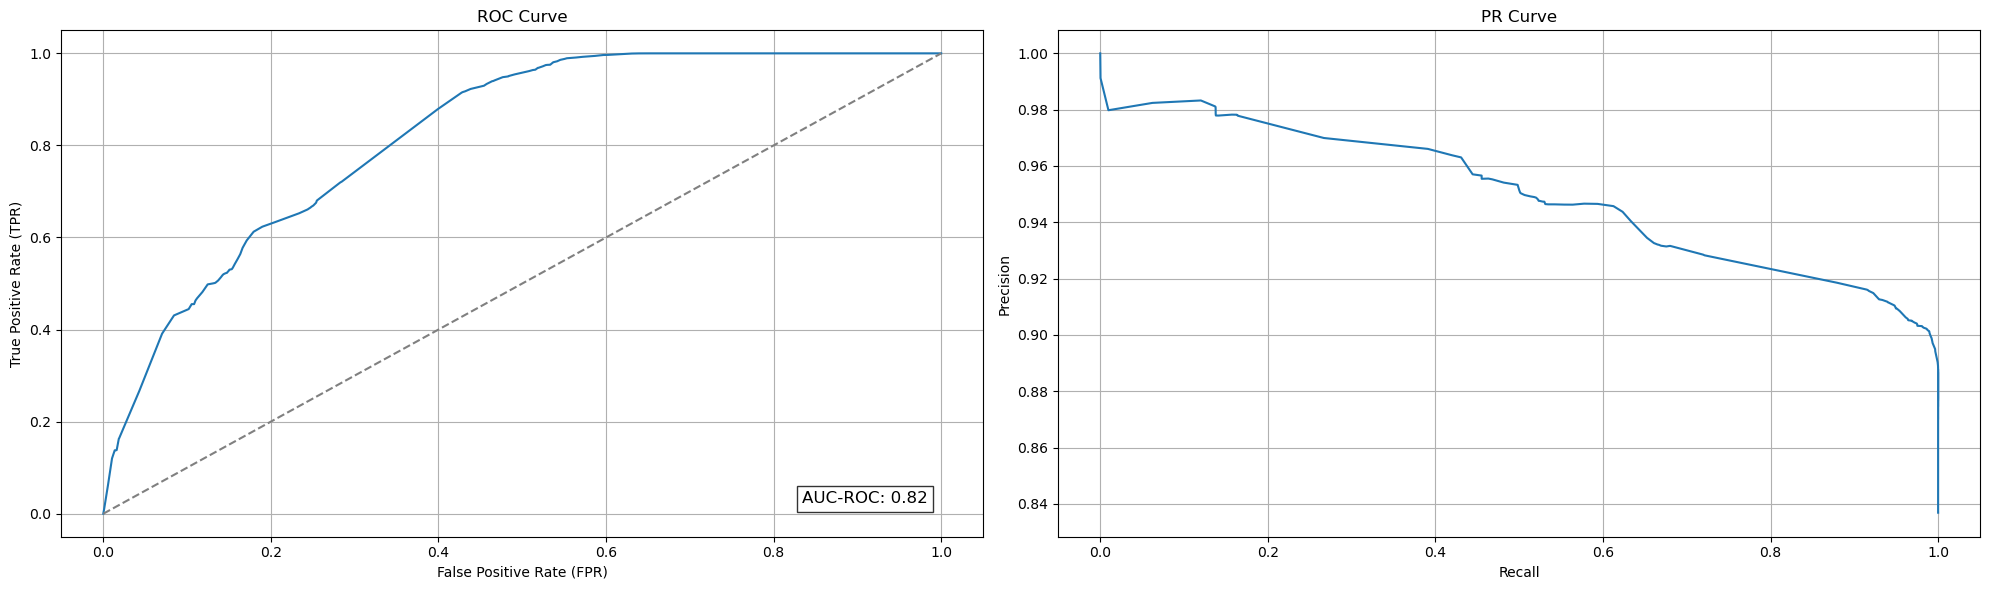

In [ ]:
# Рассчитываем AUC ROC
auc_roc = calculate_auc_roc(model=cv_model,
                            test_data=test_df,
                            label_col="congestion_surcharge")
pd_dataframe = calculate_metrics(model=cv_model,
                                 test_data=test_df,
                                 label_col="congestion_surcharge")
plot_roc_pr_curves(pd_dataframe, auc_roc)

Определим вероятность -- границу разделения, при которой `Recall` не меньше 60%.

In [ ]:
threshold_probability = pd_dataframe[pd_dataframe['TPR'] >= 0.60]['probability'].max()
print(f"Вероятность -- граница разделения, при которой TPR не меньше 60%: {threshold_probability:.2f}")

Вероятность -- граница разделения, при которой TPR не меньше 60%: 0.58


Рассчитаем метрики на тестовом датасете повторно, с учетом вычисленного `threshold` для вероятности.

In [ ]:
cv_model.bestModel.stages[-1].setThresholds([1 - threshold_probability, 
                                             threshold_probability])
test_df_predictions = cv_model.transform(test_df)
metrics = evaluate_model(test_df_predictions, "congestion_surcharge")
print(f"Metrics: {metrics}")

Metrics: {'precision': 0.9458762333762334, 'recall': 0.6109592836978923, 'f1': 0.7423929627408272}


Обученная модель обладает не очень хорошим качеством. Для дальнейшего улучшения качества предсказания можно подобрать другую модель, сформировать другие признаки, добавить к модели дополнительные данные и т.д.

Не забываем завершать `Spark`-сессию.

In [ ]:
spark.stop()